Над проектом работали:  
- Александр Калашников  
- Валентин Миронов  
- Елизавета Бердина  

In [ ]:
%load_ext autoreload
%autoreload 2
%pylab inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import shapiro

sns.set_style("darkgrid")

## Data

In [2]:
TS = pd.read_excel("./Project 2_2022.xlsx", sheet_name="Data")
TS.Date = TS.Date.apply(pd.Timestamp)
TS = TS.set_index("Date")

In [3]:
TS.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


## EDA

In [ ]:
px.line(TS, y = 'Balance', height= 400, width= 1000)

In [ ]:
px.line(TS[TS['Balance'] != 0], y = 'Balance', height= 400, width= 1000)

In [ ]:
# проверка на нормальный закон
fig = px.histogram(TS, x = 'Balance',height= 400, width= 1000)
fig.show()

stat, p = shapiro(TS.Balance)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
fig1 = px.histogram(TS[TS['Balance'] != 0], x = 'Balance')
fig1.show()

stat, p = shapiro(TS[TS['Balance'] != 0].Balance)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
# делаем предположение о нормальном законе распределения исходя из размера выборки

In [ ]:
#если возьмем разности
TS_diff = TS[TS['Balance']!= 0].diff().dropna()
px.line(TS_diff, y = 'Balance',height= 400, width= 1000)
# проверка на нормальный закон
fig = px.histogram(TS_diff, x = 'Balance', height = 400, width = 1000)
fig.show()

stat, p = shapiro(TS_diff.Balance)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
# делаем предположение о нормальном законе распределения

## Anomalies

Описание этого говна через квантильный коридор

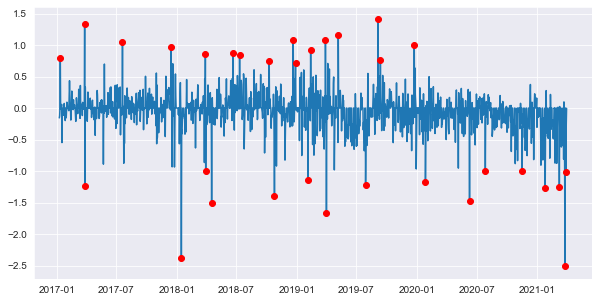

In [4]:
from modules.anomaly import detect_anomalies

anomaly_indexes = detect_anomalies(TS.Balance, thres=0.01, visualize=True)

In [5]:
anomaly_indexes.tolist()

[Timestamp('2017-01-12 00:00:00'),
 Timestamp('2017-03-27 00:00:00'),
 Timestamp('2017-07-20 00:00:00'),
 Timestamp('2017-12-15 00:00:00'),
 Timestamp('2018-03-29 00:00:00'),
 Timestamp('2018-06-21 00:00:00'),
 Timestamp('2018-07-11 00:00:00'),
 Timestamp('2018-10-09 00:00:00'),
 Timestamp('2018-12-21 00:00:00'),
 Timestamp('2018-12-28 00:00:00'),
 Timestamp('2019-02-12 00:00:00'),
 Timestamp('2019-03-29 00:00:00'),
 Timestamp('2019-05-07 00:00:00'),
 Timestamp('2019-09-05 00:00:00'),
 Timestamp('2019-09-12 00:00:00'),
 Timestamp('2019-12-24 00:00:00'),
 Timestamp('2017-03-28 00:00:00'),
 Timestamp('2018-01-15 00:00:00'),
 Timestamp('2018-03-30 00:00:00'),
 Timestamp('2018-04-17 00:00:00'),
 Timestamp('2018-10-25 00:00:00'),
 Timestamp('2019-02-04 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-07-29 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-06-09 00:00:00'),
 Timestamp('2020-07-27 00:00:00'),
 Timestamp('2020-11-16 00:00:00'),
 Timestamp('2021-01-

## Feature generation

In [11]:
from modules.feature_generation import generate_features

X, y = generate_features(TS[["Balance"]], max_timeshift=30, min_timeshift=10)

Feature Extraction: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


## Feature selection

In [12]:
from modules.feature_selection import select_features, test_stability

selected_features = select_features(X, y)

In [14]:
stability = test_stability(X, y, n_iterations=10)
stability

100%|██████████| 10/10 [02:41<00:00, 16.12s/it]


{'OLS recursive': 0.5051672320688885,
 'correlation': 0.6235104669887278,
 'mutual_info': 0.3971401781528362,
 'random_forest': 0.684089364267118,
 'lgbm': 0.6938627299570657,
 'ensemble': 0.6651789851080212}

## Shiryaev-Roberts

In [ ]:
from сhange_point_detection import detection_change_point, add_training_change_point

stat_trajectory = detection_change_point(TS.Balance, visualize = True)
add_training_change_point(stat_trajectory)

## Modeling

In [15]:
from modules.train import train_model

Best MAE: 0.20573664408070738


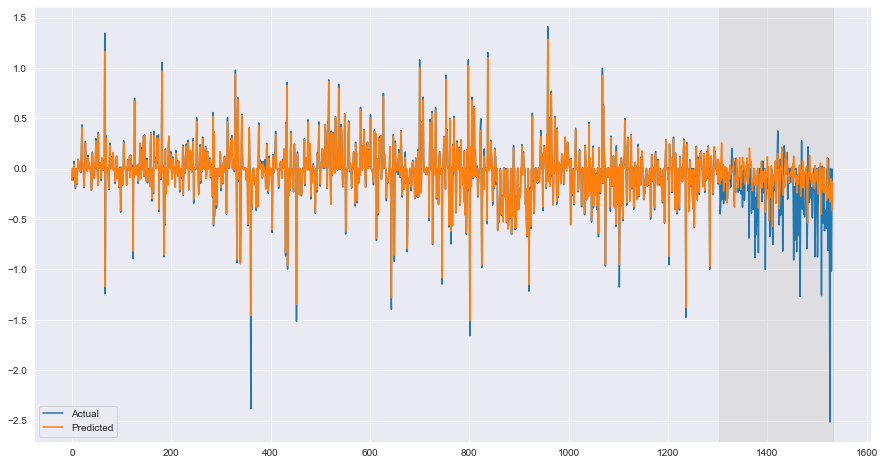

In [22]:
model_params = {
    "learning_rate": 0.1,
    "n_estimators": 200,
}

model = train_model(X[X.columns[selected_features["ensemble"]]], y, test_size=0.15, visualize=True, **model_params)